# Forecast skill 

This notebook contains a summary of some skill results to date

In [12]:
import cftime

import xarray as xr
import xskillscore as xs

import matplotlib.pyplot as plt

from src import plot

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
SKILL_DIR = "../../data/skill/"

## Sea surface temperature
### Anomaly correlation coefficient relative to HadISST

In [5]:
f6_annual_rXY = xr.open_zarr(
    f"{SKILL_DIR}/CAFEf6.HadISST.annual.anom_1991-2020.sst.rXY_1991-2020.zarr"
).compute()

f6_4year_rXY = xr.open_zarr(
    f"{SKILL_DIR}/CAFEf6.HadISST.4-year.anom_1991-2020.sst.rXY_1991-2020.zarr"
).compute()

In [6]:
can_annual_rXY = xr.open_zarr(
    f"{SKILL_DIR}/CanESM5.HadISST.annual.anom_1985-2014.sst.rXY_1985-2014.zarr"
).compute()

can_4year_rXY = xr.open_zarr(
    f"{SKILL_DIR}/CanESM5.HadISST.4-year.anom_1985-2014.sst.rXY_1985-2014.zarr"
).compute()

In [7]:
ec_annual_rXY = xr.open_zarr(
    f"{SKILL_DIR}/EC_Earth3.HadISST.annual.anom_1985-2014.sst.rXY_1985-2014.zarr"
).compute()

ec_4year_rXY = xr.open_zarr(
    f"{SKILL_DIR}/EC_Earth3.HadISST.4-year.anom_1985-2014.sst.rXY_1985-2014.zarr"
).compute()

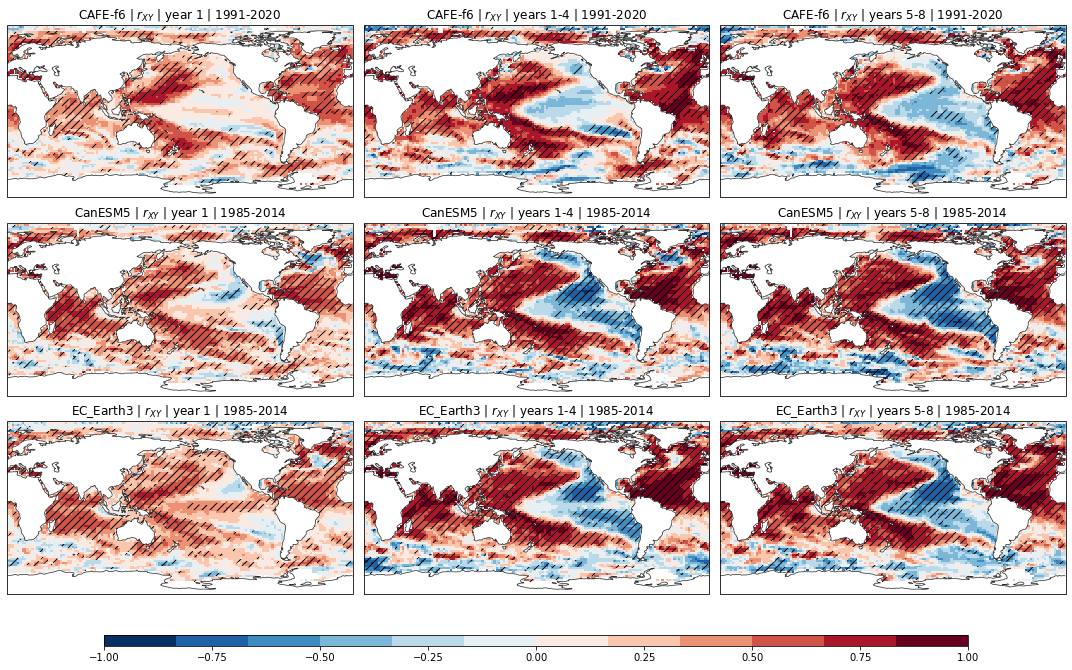

In [8]:
metric = "$r_{XY}$"

_ = plot.skill_maps(
    [
        [
            f6_annual_rXY.sel(lead=23),
            f6_4year_rXY.sel(lead=59),
            f6_4year_rXY.sel(lead=107),
        ],
        [
            can_annual_rXY.sel(lead=23),
            can_4year_rXY.sel(lead=59),
            can_4year_rXY.sel(lead=107),
        ],
        [
            ec_annual_rXY.sel(lead=23),
            ec_4year_rXY.sel(lead=59),
            ec_4year_rXY.sel(lead=107),
        ],
    ],
    variable="sst",
    vrange=(-1, 1),
    headings=[
        [
            f"CAFE-f6 | {metric} | year 1",
            f"CAFE-f6 | {metric} | years 1-4",
            f"CAFE-f6 | {metric} | years 5-8",
        ],
        [
            f"CanESM5 | {metric} | year 1",
            f"CanESM5 | {metric} | years 1-4",
            f"CanESM5 | {metric} | years 5-8",
        ],
        [
            f"EC_Earth3 | {metric} | year 1",
            f"EC_Earth3 | {metric} | years 1-4",
            f"EC_Earth3 | {metric} | years 5-8",
        ],
    ],
)

#### What are those big patches of negative correlation in the Pacific the 4-year averages?
These aren't apparent in the CanESM5 verification paper. Are they an artifact of differing "trends" over the short verifcation period? Let's look at the skill of CanESM5 and EC_Earth3 over a longer (1969-2020) period of time

In [9]:
can_4year_rXY = xr.open_zarr(
    f"{SKILL_DIR}/CanESM5.HadISST.4-year.anom_1985-2014.sst.rXY_1969-2020.zarr"
).compute()

ec_4year_rXY = xr.open_zarr(
    f"{SKILL_DIR}/EC_Earth3.HadISST.4-year.anom_1985-2014.sst.rXY_1969-2020.zarr"
).compute()

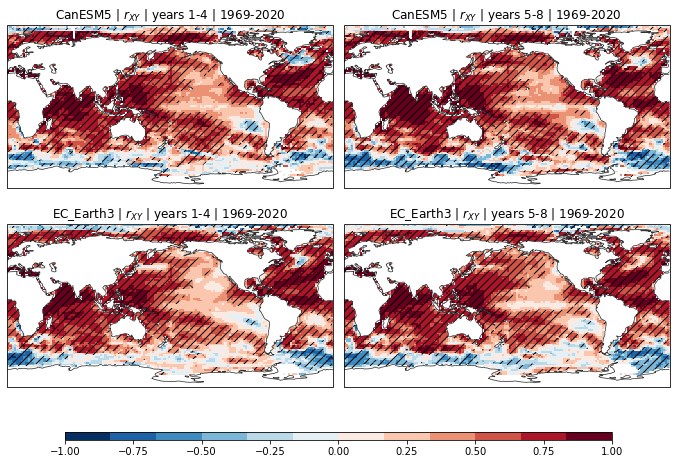

In [10]:
metric = "$r_{XY}$"

_ = plot.skill_maps(
    [
        [can_4year_rXY.sel(lead=59), can_4year_rXY.sel(lead=107)],
        [ec_4year_rXY.sel(lead=59), ec_4year_rXY.sel(lead=107)],
    ],
    variable="sst",
    vrange=(-1, 1),
    headings=[
        [f"CanESM5 | {metric} | years 1-4", f"CanESM5 | {metric} | years 5-8"],
        [f"EC_Earth3 | {metric} | years 1-4", f"EC_Earth3 | {metric} | years 5-8"],
    ],
    figsize=(9.5, 7),
)

This looks more like the results in the CanESM5 verification paper. So we need to be pretty careful interpretting the anomaly correlation coefficient over out short verification period. Let's demonstrate this by looking at the hindcast and observed timeseried at a location in the Pacific:

In [13]:
location = dict(lon=225, lat=10)
full_period = slice("1969", "2020")
verif_period = slice("1985", "2014")

hcst = xr.open_zarr("../../data/processed/CanESM5.4-year.anom_1985-2014.sst.zarr").sel(
    location, method="nearest"
)
hcst = (
    hcst["sst"]
    .mean("member")
    .sel(lead=59)
    .swap_dims({"init": "time"})
    .sel(time=full_period)
)

obsv = xr.open_zarr("../../data/processed/HadISST.4-year.anom_1985-2014.sst.zarr").sel(
    location, method="nearest"
)
obsv = obsv["sst"].sel(time=hcst.time)

acc_full_period = xs.pearson_r(hcst, obsv, dim="time").values.item()

acc_verif_period = xs.pearson_r(
    hcst.sel(time=verif_period), obsv.sel(time=verif_period), dim="time"
).values.item()

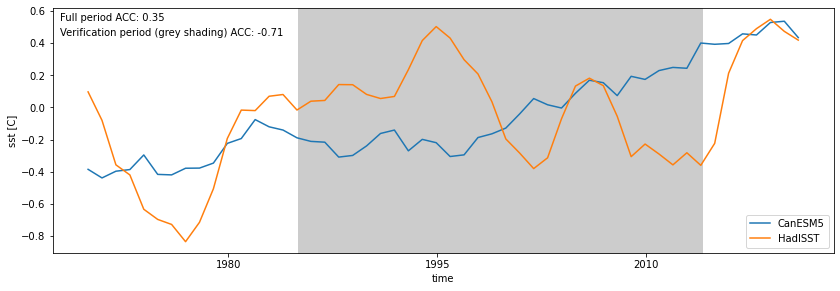

In [16]:
fig, ax = plt.subplots(figsize=(14, 4.5))

hcst.plot(label="CanESM5")
obsv.plot(label="HadISST")
ylim = plt.gca().get_ylim()
plt.fill_between(
    [cftime.datetime(1985, 1, 1), cftime.datetime(2014, 1, 1)],
    [ylim[0], ylim[0]],
    [ylim[1], ylim[1]],
    color=[0.8, 0.8, 0.8],
)
plt.gca().set_ylim(ylim)
plt.title("")
plt.legend(loc="lower right")

plt.text(
    0.01,
    0.98,
    f"Full period ACC: {acc_full_period:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
)
_ = plt.text(
    0.01,
    0.92,
    f"Verification period (grey shading) ACC: {acc_verif_period:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=ax.transAxes,
)